In [1]:
import os.path
import cv2 as cv
import numpy as np
from random import randrange
from matplotlib import pyplot as plt
from matplotlib.patches import ConnectionPatch

In [10]:
class Project:
    
    @property
    def Images(self):
        return self.__images
    
    @Images.setter
    def Images(self, images):
        if not isinstance(images, list):
            raise TypeError("expected list of Images")
        
        for image in images:
            if not isinstance(image, Image):
                raise TypeError("expected list of Images")
        
        self.__images += images
            
    
    def __init__(self, project_root, project_name):
        self.project_root = project_root
        self.project_name = project_name
        
        self.__images = []
        
        self.InitProject()
        
    def InitProject(self):
        if not os.path.isdir(self.project_root):
            os.mkdir(self.project_root)
        
        # Prevent duplicate project names. 
        count = 1
        project_name = self.project_name
        project_path = os.path.join(self.project_root, self.project_name)        
        while os.path.isdir(project_path):
            project_name = self.project_name + str(count)
            project_path = os.path.join(self.project_root, project_name)
            count += 1
        
        self.project_name = project_name
        self.project_path = project_path
        
        os.mkdir(self.project_path)   
        
    def DetectKeypoints(self, minHessian = 400):
        surf = cv.xfeatures2d_SURF.create(hessianThreshold=minHessian)
        
        for image in self.__images:   
            print(f"calculating keypoints for {image.Path}")
            image.KeyPoints, image.Descriptors = surf.detectAndCompute(image.Gray, None) # detect features and compute descriptors.
            print(f"..found {len(image.KeyPoints)} for {image.Path}")
    
    def ComputeMatches(self, dMeasurment=cv.NORM_L2 ):
        # Create BFMatcher object.
        bf = cv.BFMatcher.create(dMeasurment , crossCheck=True)
        
        if len(self.__images) < 1:
            raise ValueError(f"at least two images are required to compute matches.")
        
        # We are searching for image matches against all other images. This
        # is very time consuming and not necessary. Implement options to
        # limit the number of match candidates. 
        for image in self.__images:            
            matches = []
            for match_to in self.__images:                
                # don't try to match the image against itself.
                if image == match_to:
                    continue
                    
                print(f"matching {image.Path} to {match_to.Path}")
                results = bf.match(image.Descriptors, match_to.Descriptors)
                # Sort them in the order of their distance.
                results = sorted(results, key = lambda x:x.distance)
                print(f"...found {len(results)}")
                
                match = Match(match_to, results)                
                matches.append(match)                
                
            image.MatchedImages = matches

class Image:
    
    @property
    def Path(self):
        return self.__image_path 
    
    @property
    def Original(self):
        return self.__image
    
    @property
    def Gray(self):
        return self.__gray_image
    
    @property
    def KeyPoints(self):
        return self.__keypoints
    
    @KeyPoints.setter
    def KeyPoints(self, keypoints):
        self.__keypoints = keypoints
        
    @property
    def Descriptors(self):
        return self.__descriptors
    
    @Descriptors.setter
    def Descriptors(self, descriptors):
        self.__descriptors = descriptors
    
    @property
    def MatchedImages(self):
        return self.__matches
    
    @MatchedImages.setter
    def MatchedImages(self, matches):
        if not isinstance(matches, list):
            raise TypeError("expected list of Matches")
            
        for match in matches:
            if not isinstance(match, Match):
                raise TypeError("expected list of Matches")
        
        self.__matches += matches
    
    def __init__(self, image_path):
        
        if os.path.isfile(image_path):
            self.__image_path = image_path
            self.__image = cv.imread(image_path) # original image as numpy array.
            self.__gray_image = cv.cvtColor(self.__image, cv.COLOR_BGR2GRAY) # grayscale image as numpy array.
        else:
            raise ValueError(f"{image_path} is not a valid image.")
            
        self.__keypoints = None 
        self.__descriptors = None
        self.__matches = []

        
class Match:
    
    @property
    def Matches(self):
        return self.__matches
    
    @property
    def MatchedTo(self):
        return self.__to_image
    
    def __init__(self, to_image, matches):
        self.__to_image = to_image
        self.__matches = matches

In [11]:
# Create project
my_project = Project(r"C:\Users\mar10675\Documents\FeatureMatching", "my_project")

# Add images to project.
image0 = Image(r"C:\Users\mar10675\JupyterOnGitHub\Images\cat.jpg")
image1 = Image(r"C:\Users\mar10675\JupyterOnGitHub\Images\cat.jpg")

#image0 = Image(r"C:\Users\mar10675\JupyterOnGitHub\Images\SceauxCastle\100_7101.jpg")
#image1 = Image(r"C:\Users\mar10675\JupyterOnGitHub\Images\SceauxCastle\100_7107.jpg")
my_project.Images = [image0, image1]

calculating keypoints for C:\Users\mar10675\JupyterOnGitHub\Images\cat.jpg
..found 718 for C:\Users\mar10675\JupyterOnGitHub\Images\cat.jpg
calculating keypoints for C:\Users\mar10675\JupyterOnGitHub\Images\cat.jpg
..found 718 for C:\Users\mar10675\JupyterOnGitHub\Images\cat.jpg


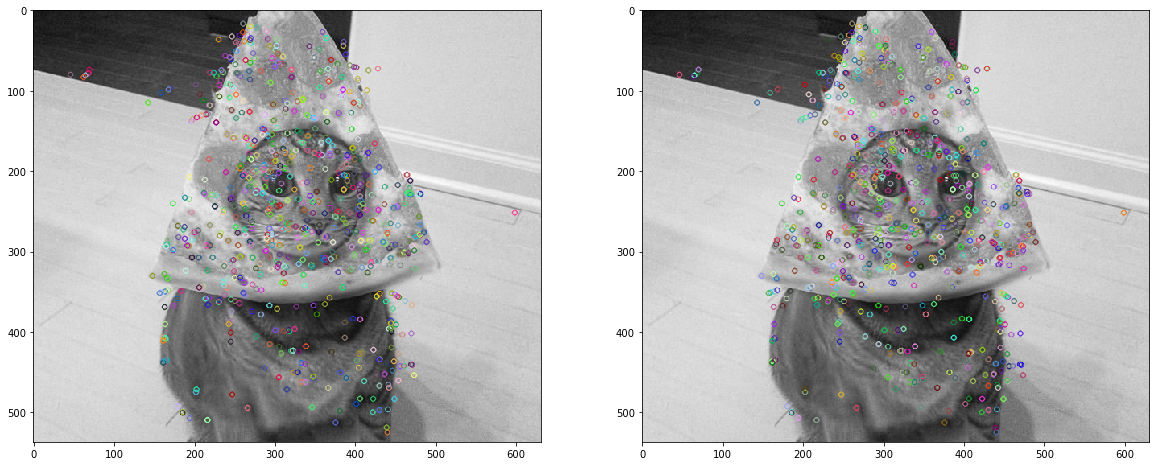

In [12]:
# Process keypoints.
my_project.DetectKeypoints(400) # default 400.

# Grab the first two images from the project.
img0 = my_project.Images[0]
img1 = my_project.Images[1]

# Draw the keypoints on each image. 
result0 = cv.drawKeypoints(img0.Gray, img0.KeyPoints, img0.Gray)
result1 = cv.drawKeypoints(img1.Gray, img1.KeyPoints, img1.Gray)

# Plot the images with their keypoints.
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(result0)
ax2.imshow(result1)

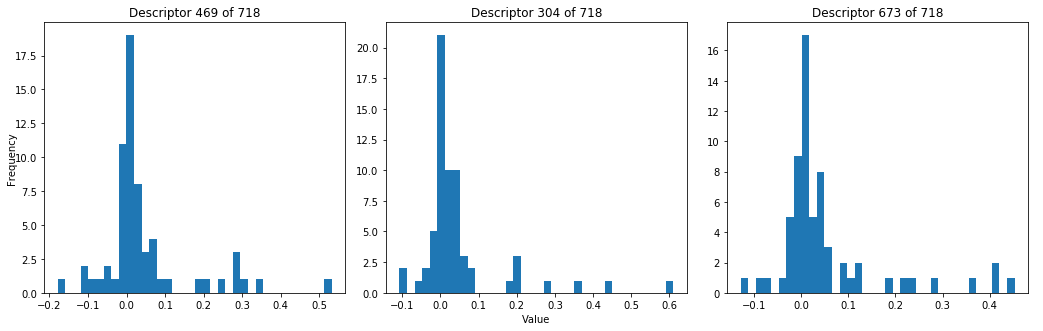

In [13]:
# Plot random descriptors from the first image.
descriptor_length = len(img0.Descriptors)

i0 = randrange(0, descriptor_length)
i1 = randrange(0, descriptor_length)
i2 = randrange(0, descriptor_length)

fig = plt.figure(figsize=(15, 5))
ax0 = fig.add_subplot(111) 
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.hist(img0.Descriptors[i0], density=False, bins=36)
ax2.hist(img0.Descriptors[i1], density=False, bins=36)
ax3.hist(img0.Descriptors[i2], density=False, bins=36)

# Turn off axis lines and ticks of the big subplot
ax0.spines['top'].set_color('none')
ax0.spines['bottom'].set_color('none')
ax0.spines['left'].set_color('none')
ax0.spines['right'].set_color('none')
ax0.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

# Set common labels
ax0.set_xlabel('Value')
ax0.set_ylabel('Frequency')

ax1.set_title(f"Descriptor {i0} of {descriptor_length}")
ax2.set_title(f"Descriptor {i1} of {descriptor_length}")
ax3.set_title(f"Descriptor {i2} of {descriptor_length}")

plt.tight_layout()
plt.show()

In [14]:
my_project.ComputeMatches()

matching C:\Users\mar10675\JupyterOnGitHub\Images\cat.jpg to C:\Users\mar10675\JupyterOnGitHub\Images\cat.jpg
...found 718
matching C:\Users\mar10675\JupyterOnGitHub\Images\cat.jpg to C:\Users\mar10675\JupyterOnGitHub\Images\cat.jpg
...found 718


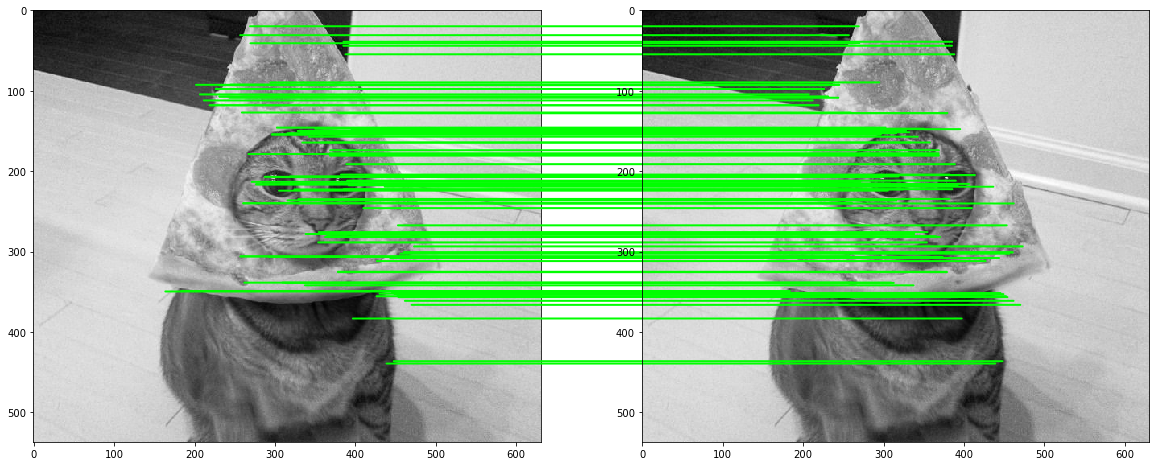

In [15]:
# Draw some matches

# The first match in the first matched image...
matches = img0.MatchedImages[0].Matches[:100]
total_matches = len(img0.MatchedImages[0].Matches)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for match in matches:

    kp0 = img0.KeyPoints[match.trainIdx]
    kp1 = img1.KeyPoints[match.queryIdx]

    con = ConnectionPatch(xyA=kp0.pt, xyB=kp1.pt, coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax1, color=(0,1,0), linewidth=2.0)

    ax2.add_artist(con)

ax1.imshow(img0.Gray, cmap='gray')
ax2.imshow(img1.Gray, cmap='gray')

plt.show()